In [3]:
import pandas as pd 
import numpy as np
#from sklearn import linear_model
#import seaborn as sns
#import matplotlib.pyplot as plt
#from sklearn import preprocessing
from itertools import groupby
import common
from os import listdir
from os.path import isfile, join

In [4]:
import asset
import backtest

In [ ]:
lenRecord = pd.read_csv('record.txt', header=False)
end = lenRecord[1]
start = np.hstack((0, end[:-1]))
df_record = pd.concat([lenRecord, pd.DataFrame({'start': start})], axis=0)

In [5]:
p_stock_id = '股票交易代码'
p_stock_title = '股票名称'
p_cash_divid_bt = '税前派现金额（人民币）（元）（1：X）'
p_date = '除权日'
p_cash_divid_at = '税后派现金额（人民币）（元）（1：X）'
p_stock_divid_rat = '送股比例（1：X）'
p_increa_trans_rat = '转增比例（1：X）'
p_reser_rat = '送转比例（1：X）'
p_allot_prc = '配股价格（元）'
p_allot_rat = '实际配股比例'

In [6]:
STOCK_LIST = ['603885']#, '000099', '000004', '000005', '000006', '399300'] 

In [581]:
# read all the tech data of stock 000001
def read_tech(path = '/home/lcc/sensequant/kline_5minute/sh/'):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    df_tech = None
    for f in files:

        date = f.split('.')[0]
        df = pd.read_csv(path+f, dtype={'stock_id': str})
        df = df[df['stock_id'].isin(STOCK_LIST)]
        df['date'] = date
        if df_tech is None:
            df_tech = df
        else:
            df_tech = pd.concat([df_tech, df])
    df_tech['date'] = pd.to_datetime(df_tech.date)
    return df_tech

In [476]:
def read_panel(fname='/home/lcc/sensequant/kline_5minute/stock_info'):
    df_panel = pd.read_csv(fname)
    df_panel = df_panel[(df_panel[p_stock_id].isin(STOCK_LIST))]
    df_panel[p_date] = pd.to_datetime(df_panel[p_date])
    return df_panel


In [385]:
# %load common.py
import numpy as np
import pandas as pd 

p_exchange_ = '交易所简称'
p_stock_id_ = '股票代码'
p_date_ = '时间'
p_earn_per_share_ = '每股收益(元)'
p_bvps_ = '每股净资产(元)'
p_roe_ = '净资产收益率(％)'
p_net_profit_ = '净利润(万元)'
p_npgr_ = '净利润增长率(%)'
p_wroe_ = '加权净资产收益率(%)'
p_asset_liability_ratio_ = '资产负债比率(%)'
p_cash_in_net_profit_ = '净利润现金含量(%)'
p_basic_earn_per_share_ = '基本每股收益(元)'
p_net_earn_per_share_ = '每股收益-扣除(元)'
p_dulute_earn_per_share_ = '每股收益-摊薄(元)'
p_capital_reserve_per_share_ = '每股资本公积金(元)'
p_udpps_ = '每股未分配利润(元)'
p_epcf_ = '每股经营现金流量(元)'
p_operating_net_cash_flow_ = '经营活动现金净流量增长率(%)'
p_equity_ = '总股本(亿股)'
p_limit_equity_ = '限售股份(亿股)'
p_a_share_ = '流通A股(亿股)'

def scalify(l):
    if type(l) != np.ndarray:
        return l
    elif len(l) > 1:
        raise ValueError('Not only one element!')  
    else:
        return l[0]

def lower_bound(df, dateCol, date):
    return np.max(df[df[dateCol]<date][dateCol])

def select_val_b4_date(df, date, dateCol, valCol):
    # default: the column of the date in the df is dateCol
    lb = np.max(df[df[dateCol]<=date][dateCol])
    return df[df[dateCol]==lb][valCol].values
    
def record_error_msge(id_, msge, fname='cache/errorLog.txt'):
    with open(fname, 'a') as f:
        f.write(id_+'\t'+msge+'\n')

def normalize_dict(dict_):
    sum_ = sum(list(dict_.values()))
    for k, v in dict_.items():
        dict_[k] = v / sum_
    return dict_

In [268]:
df4test = pd.read_csv('cache.txt')
df4test = df4test.drop('index', axis=1)
#algorithm = ALGORITHM()
#algorithm.run()

In [393]:
d = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}

In [423]:
list(d.keys())

['b', 'e', 'c', 'a', 'd']

In [428]:
(np.array([3, 3, 10, 2, 2, 3,4,5]) > 0).all()

True

In [22]:
def adjust_price(price, cash_divid_at, reser_rat):
    return (price - float(cash_divid_at)) / (1 + float(reser_rat))

In [478]:
df_copy = df_tech.copy()
df = df_panel[[p_stock_id, p_cash_divid_bt, p_cash_divid_at, p_reser_rat, p_date]]
for values in df.itertuples():
    stock_id = values[1]
    cash_divid_bt = values[2]
    cash_divid_at = values[3]
    reser_rat = values[4]
    #print (reser_rat)
    date = values[5]
    if cash_divid_bt != '\\N':
        c = cash_divid_at
    elif cash_divid_at != '\\N':
        c = cash_divid_bt
    else:
        c = 0
    criteria = (df_copy['stock_id'] == stock_id) & (df_copy['date'] < date)
    df_copy.loc[criteria, ['high', 'low', 'open', 'close']] = df_copy[criteria][['high', 'low', 'open', 'close']].apply(adjust_price, args=(c, reser_rat,))
    


In [479]:
groups = df_copy.groupby(['stock_id', 'date'])
col = ['stock_id', 'date', 'high', 'low', 'open', 'close']
df_y = pd.DataFrame()
for name, group in groups:
    if group.high.max() <= 0:
        continue
    stock_id = name[0]
    date = name[1]
    high = group.high.max()
    low = group[group['low']>0].low.min()
    open_ = group[(group['open'].astype(np.float))>0].iloc[0]['open']
    close = group.iloc[-1]['close']
    row = pd.Series([stock_id, date, high, low, open_, close])
    df_y = df_y.append(row, ignore_index=True)
df_y.columns = col

# Construct the Indicator 

In [44]:
p_exchange_ = '交易所简称'
p_stock_id_ = '股票代码'
p_date_ = '时间'
p_earn_per_share_ = '每股收益(元)'
p_bvps_ = '每股净资产(元)'
p_roe_ = '净资产收益率(％)'
p_net_profit_ = '净利润(万元)'
p_npgr_ = '净利润增长率(%)'
p_wroe_ = '加权净资产收益率(%)'
p_asset_liability_ratio_ = '资产负债比率(%)'
p_cash_in_net_profit_ = '净利润现金含量(%)'
p_basic_earn_per_share_ = '基本每股收益(元)'
p_net_earn_per_share_ = '每股收益-扣除(元)'
p_dulute_earn_per_share_ = '每股收益-摊薄(元)'
p_capital_reserve_per_share_ = '每股资本公积金(元)'
p_udpps_ = '每股未分配利润(元)'
p_epcf_ = '每股经营现金流量(元)'
p_operating_net_cash_flow_ = '经营活动现金净流量增长率(%)'
p_equity_ = '总股本(亿股)'
p_limit_equity_ = '限售股份(亿股)'
p_a_share_ = '流通A股(亿股)'

In [1]:
def fast_read_tech(path='/home/lcc/sensequant/kline_5minute/alldata/', id_='000166'):
    files = [f for f in listdir(path) if isfile(join(path, f)) and f.split('.')[0] == id_]
    df_tech = None
    for f in files:
        df_tech = pd.read_csv(path+f, dtype={'stock_id': str})
        df_tech['date'] = pd.to_datetime(df_tech.date, format='%Y%m%d')
        #14000 => 14.000
        df_tech[['high', 'low', 'open', 'close']] = df_tech[['high', 'low', 'open', 'close']].apply(lambda x: x/1000)
        groups = df_tech.groupby('date')
        col = ['stock_id', 'date', 'high', 'low', 'open', 'close']
        df_y = pd.DataFrame()
        for name, group in groups:
            if group.high.max() <= 0:
                continue
            stock_id = id_
            date = name
            high = group.high.max()
            low = group[group['low']>0].low.min()
            open_ = group[(group['open'].astype(np.float))>0].iloc[0]['open']
            close = group.iloc[-1]['close']
            row = pd.Series([stock_id, date, high, low, open_, close])
            df_y = df_y.append(row, ignore_index=True)
        df_y.columns = col 
    if df_tech is None:
        return df_tech
    else:
        return df_y               

In [ ]:
df_y = fast_read_tech()

In [2]:
df = df_y
df[df.date==np.sort(df.date)[-2]].close

NameError: name 'df_y' is not defined

In [149]:
STOCK300 = [line.rstrip() for line in open('hushen_300_.txt')]
STOCK500 = [line.rstrip() for line in open('zhongzheng_500_.txt')]
STOCK800 = STOCK300+STOCK500

In [38]:
df = pd.read_excel('000300closeweight.xls', 'sheet1', converters={'Constituent Code': str})
df = df[['Constituent Code', 'Weight(%)']]
df.to_csv('data/weight.txt', index=False)

In [853]:
STOCK_LIST = ['000166']

In [854]:
df_finance = pd.read_csv('/home/lcc/sensequant/kline_5minute/stock_finance.txt', dtype={p_stock_id_: str})
df_finance = df_finance.drop('每股净资产(元).1', 1)
df_finance = df_finance[df_finance[p_stock_id_].isin(STOCK_LIST)].reset_index(drop=True)
df_finance[p_date_] = pd.to_datetime(df_finance[p_date_])
df_finance['year'] = df_finance[p_date_].apply(lambda time: time.year)
df_finance['month'] = df_finance[p_date_].apply(lambda time: time.month)
df_finance['day'] = df_finance[p_date_].apply(lambda time: time.day)
df_finance

,交易所简称,股票代码,股票名称,时间,每股收益(元),每股净资产(元),净资产收益率(％),净利润(万元),净利润增长率(%),加权净资产收益率(%),...,基本每股收益(元),每股收益-扣除(元),每股收益-摊薄(元),每股资本公积金(元),每股未分配利润(元),每股经营现金流量(元),经营活动现金净流量增长率(%),year,month,day
0,SZ,000166,申万宏源,2016-03-31,0.07,3.3679,2.0919,106699.02,-47.851339,2.09,...,0.07,NaN,0.070453,0.299187,1.432424,-0.8479,-137.402563,2016,3,31
1,SZ,000166,申万宏源,2015-12-31,0.82,3.3812,24.1950,1242843.57,122.130466,27.41,...,0.82,0.82,0.818092,0.299187,1.362584,3.3967,33.031506,2015,12,31
2,SZ,000166,申万宏源,2015-09-30,0.57,3.1300,18.0768,863531.57,161.223090,19.96,...,0.57,NaN,0.565049,0.299784,1.340491,3.5700,159.232687,2015,9,30
3,SZ,000166,申万宏源,2015-06-30,0.50,3.1091,15.9255,751547.36,291.500273,17.38,...,0.50,0.50,0.495134,0.299784,1.209795,7.1279,1439.825875,2015,6,30
4,SZ,000166,申万宏源,2015-03-31,0.13,2.7718,6.2325,261685.69,147.481166,6.23,...,0.13,NaN,0.134333,0.528625,0.778346,2.2670,864.227637,2015,3,31
5,SZ,000166,申万宏源,2014-12-31,0.40,4.7186,14.7744,350443.42,190.079195,15.90,...,0.40,0.49,0.697148,0.893031,1.584844,5.6485,849.952619,2014,12,31
6,SZ,000166,申万宏源,2014-08-31,NaN,2.3600,7.6667,NaN,NaN,7.82,...,NaN,0.18,NaN,NaN,NaN,0.5000,NaN,2014,8,31
7,SZ,000166,申万宏源,2014-06-30,0.14,NaN,NaN,104119.83,153.375933,5.45,...,0.14,0.16,0.238504,0.030422,0.975629,1.0240,NaN,2014,6,30
8,SZ,000166,申万宏源,2013-12-31,0.28,2.7465,10.2122,192882.03,34.873860,10.56,...,0.28,NaN,0.280478,NaN,1.005490,-0.7532,-110.659184,2013,12,31


In [60]:
def select_val_b4_date(df, date, dateCol, valCol):
    # default: the column of the date in the df is dateCol
    lb = np.max(df[df[dateCol]<date][dateCol])
    return df[df[dateCol]==lb][valCol].values

In [855]:
df_share = pd.read_csv('/home/lcc/sensequant/kline_5minute/stock_share.txt', dtype={p_stock_id_: str})
df_share = df_share[df_share[p_stock_id_].isin(STOCK_LIST)]
df_share[p_date_] = pd.to_datetime(df_share[p_date_])


In [104]:
from common import scalify

In [487]:
# %load indicators.py
import pandas as pd 
import numpy as np 
from common import scalify, lower_bound, select_val_b4_date, record_error_msge
from tempfile import TemporaryFile
import matplotlib.pyplot as plt

p_exchange_ = '交易所简称'
p_stock_id_ = '股票代码'
p_date_ = '时间'
p_earn_per_share_ = '每股收益(元)'
p_bvps_ = '每股净资产(元)'
p_roe_ = '净资产收益率(％)'
p_net_profit_ = '净利润(万元)'
p_npgr_ = '净利润增长率(%)'
p_wroe_ = '加权净资产收益率(%)'
p_asset_liability_ratio_ = '资产负债比率(%)'
p_cash_in_net_profit_ = '净利润现金含量(%)'
p_basic_earn_per_share_ = '基本每股收益(元)'
p_net_earn_per_share_ = '每股收益-扣除(元)'
p_dulute_earn_per_share_ = '每股收益-摊薄(元)'
p_capital_reserve_per_share_ = '每股资本公积金(元)'
p_udpps_ = '每股未分配利润(元)'
p_epcf_ = '每股经营现金流量(元)'
p_operating_net_cash_flow_ = '经营活动现金净流量增长率(%)'
p_equity_ = '总股本(亿股)'
p_limit_equity_ = '限售股份(亿股)'
p_a_share_ = '流通A股(亿股)'

class INDICATOR():
    def __init__(self, df_y, df_finance, df_share):
        self.M = 9
        self.N = 5
        self.U = 26
        self.df_y = df_y
        self.df_finance = df_finance
        self.df_share = df_share
        self.df_finance['average_asset_ratio_in_last_one_year'] = df_finance.apply(lambda row: np.average(df_finance.loc[row.name:row.name+4, p_asset_liability_ratio_].values), axis=1)
        self.df_finance['average_cash_ratio_in_last_one_year'] = df_finance.apply(lambda row: np.average(df_finance.loc[row.name:row.name+4, p_epcf_].values), axis=1)
        self.df_finance['eps_in_past_one_year'] = self.df_finance.apply(lambda row: self._get_eps_in_one_year(self.df_finance[row.name:row.name+5]), 1)
        self.id_ = scalify(self.df_y.stock_id.unique())

    def _slope_N_day(self, c0, cN, N):
        return ((c0 - cN) / cN) / N

    def _percentile_N_day(self, c0, H, L):
        return (c0 - L) / (H - L)

    def _ema(self, c_array):
        day = len(c_array)
        mul = 2 / (day + 1)
        if day == 1:
            return c_array.index[0]
        else:
            return (c_array.index[-1] - ema(c_array[:-1])) * mul + ema(c_array[:-1])

    def _price_oscillator(self, c_array, M=9, N=12):
        if M > len(c_array) or N > len(c_array):
            raise ValueError('M or N is bigger than the number of days')
        return (ema(c_array[-M:]) - ema(c_array[-N:])) / ema(c_array[-N:])

    def _recur_diff(self, array, result_array=None):
        l = len(array)
        if l > 1:
            diff = (array[0] - array[1]) / array[0]
            if result_array is None:
                result_array = np.array([diff])
            else:
                result_array = np.append(result_array, diff)
            return recur_diff(array[1:], result_array)
        else:
            return result_array

    def _volume_N_day(self, V, C):
        return np.sum(V * recur_diff(C)) 

    def _return_N_day(self, c0, cN):
        return (c0 - cN) / cN

    def _cal_ema(self, df, M):
        df = df.reset_index(drop=True)
        mul = 2 / (M + 1)
        ema = np.full(len(df), -np.inf)
        ema[0] = df.loc[0, 'close'] * mul
        for index in range(1, len(ema)):
            ema[index] = (df.loc[index, 'close'] - ema[index-1]) * mul + ema[index-1]
        return ema

    def construct_slope_N_day(self):
        return self.df_y.loc[self.N:].apply(lambda row: self._slope_N_day(row['close'], self.df_y.loc[row.name-self.N,'close'], self.N), axis=1)

    def construct_percentile_N_day(self):
        return self.df_y.loc[self.N:].apply(lambda row: self._percentile_N_day(row['close'],\
                                                        self.df_y.loc[row.name-self.N:row.name+1, 'high'].max(),\
                                                        self.df_y.loc[row.name-self.N:row.name+1, 'low'].min()\
                                            ), axis=1)

    def construct_return_N_day(self):
        return self.df_y.loc[self.N:].apply(lambda row: self._return_N_day(row.close, self.df_y.loc[row.name-self.N, 'close']), axis=1) 

    def construct_ema(self):
        emaM = self._cal_ema(self.df_y[self.N:], self.M)
        emaU = self._cal_ema(self.df_y[self.N:], self.U)
        print ('emaM: {0}; emaU: {1}'.format(np.shape(emaM), np.shape(emaU)))
        return (emaM - emaU) / emaU

    def pe_ratio(self):
        return self.df_y[self.N:].apply(lambda row: \
                                            scalify(\
                                                    select_val_b4_date(self.df_finance, row.date, p_date_, 'eps_in_past_one_year')/\
                                                    row.close\
                                                    ), axis=1)
    
    def relative_pe_ratio(pe, avepe):
        return pe / avepe
    
    def pb_ratio(self):
        return self.df_y[self.N:].apply(lambda row:  row.close/\
                                                     scalify(\
                                                           self.df_finance[\
                                                           (self.df_finance[p_date_]==lower_bound(self.df_finance, row.date, p_date_))\
                                                           &(~self.df_finance[p_bvps_].isnull())][p_bvps_].values\
                                                            )

                                        , axis=1)
    
    def relative_pb_ratio(pb, avepb):
        return pb / avepb
    
    def current_cashflow_ratio(self):
        return self.df_y[self.N:].apply(lambda row: scalify(row.close / select_val_b4_date(self.df_finance, row.date, p_date_, p_epcf_)), axis=1)
    
    def average_cashflow_ratio(self):
        return self.df_y[self.N:].apply(lambda row: scalify(row.close / select_val_b4_date(self.df_finance, row.date, p_date_, 'average_cash_ratio_in_last_one_year')), axis=1)
    
    def current_debt_ratio(self):
        return self.df_y[self.N:].apply(lambda row: scalify(select_val_b4_date(self.df_finance, row.date, p_date_, p_asset_liability_ratio_)), axis=1)

    def average_debt_ratio(self):
        return self.df_y[self.N:].apply(lambda row: scalify(select_val_b4_date(self.df_finance, row.date, p_date_, 'average_asset_ratio_in_last_one_year')), axis=1)
    
    def market_capitalization(self):
        return self.df_y[self.N:].apply(lambda row: scalify(row.close * select_val_b4_date(self.df_share, row.date, p_date_, p_equity_)), axis=1)
    
    def circulate_stock_value(self):
        return self.df_y[self.N:].apply(lambda row: scalify(row.close * select_val_b4_date(self.df_share, row.date, p_date_, p_a_share_)), axis=1)

    def _eps_within_one_certain_year(self, arr):
        if len(arr) == 1:
            return arr
        elif len(arr) > 4:
            raise ValueError('Impossible that more than 4 rows in one year!')
        else:
            return arr[0] - arr[-1] 

    def _get_eps_in_one_year(self, df):
        df = df.reset_index(drop=True)
        if len(df) > 5:
            raise ValueError('Plese take the first five rows as input bitch')
        bLastYear = self._eps_within_one_certain_year(\
                                        df[df.year==np.min(df.year.values)][p_earn_per_share_].values)
        bThisYear = df[df.year==np.max(df.year.values)].loc[0, p_earn_per_share_]
        return scalify(bLastYear+bThisYear)

    def save_img(self, arr, fname, folder='graph/'):
        fig,ax = plt.subplots()  #create a new figure
        ax.plot(arr)
        fig.savefig(folder+fname)

    def implement_indicator(self):
        slopeNday = self.construct_slope_N_day()
        percentileNday = self.construct_percentile_N_day()
        returnNday = self.construct_return_N_day()
        #self.save_img(returnNday, self.id_+'_'+'returnNday.png')
        ema = self.construct_ema()
        pe = self.pe_ratio()
        self.save_img(pe, self.id_+'_'+'pe.png')
        pb = self.pb_ratio()
#        self.save_img(pb, self.id_+'_'+'pb.png') 
        currCashRat = self.current_cashflow_ratio()
#        self.save_img(currCashRat, self.id_+'_'+'currCashRat.png')        
        aveCashRat =  self.average_cashflow_ratio()
        currDebtRat = self.current_debt_ratio()
        aveDebtRat =  self.average_debt_ratio()
        marketVal = self.market_capitalization()
        #self.save_img(marketVal, self.id_+'_'+'marketval.png')
        circuMarketVal = self.circulate_stock_value()
        #self.save_img(circuMarketVal, self.id_+'_'+'circulmarketval.png')
        return np.vstack((slopeNday, 
                          percentileNday, 
                          returnNday, 
                          ema, 
                          pe, 
                          pb, 
                          currCashRat, 
                          aveCashRat, 
                          currDebtRat, 
                          aveDebtRat, 
                          marketVal, 
                          circuMarketVal))
    
    def _tomorrow_trend(self, close1, close2, threshold=0):
        # close1: tomorrow
        # close2: today
        trend = (close1 - close2) / close2
        if trend > threshold:
            return 2
        elif -threshold < trend < threshold:
            return 1
        else:
            return 0
            
    def _get_trend(self):
        return self.df_y[self.N:-1].apply(lambda row: self._tomorrow_trend(self.df_y.loc[row.name+1, 'close'], row.close), axis=1).values

    def save_indicators(self):
        # shape(output) should be num_data * (num_ind + 1)

        indicators = self.implement_indicator()
        
        # filter the null val       
        indicators = indicators[:, :-1]
        #if np.isnan(indicators).any():
        #    record_error_msge(self.id_, 'has null val')
        #    return False

        trend = self._get_trend()
        trend = trend.reshape(len(trend), 1)
        return indicators


In [856]:
df_y = fast_read_tech()

In [864]:
df_y.to_hdf('store.h5', 'table2', append = True)

In [863]:
type(pd.read_hdf('store.h5', 'table'))

pandas.core.frame.DataFrame

In [857]:
ind = INDICATOR(df_y, df_finance, df_share)

emaM: (241,); emaU: (241,)


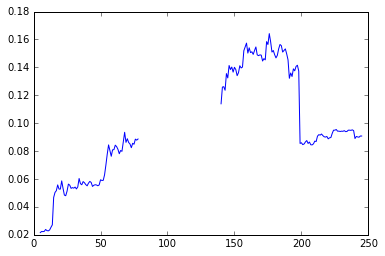

In [858]:
a = ind.save_indicators()

In [859]:
for i in range(12):
    print (str(i), np.unique(np.isnan(a[i])))

0 [False]
1 [False]
2 [False]
3 [False]
4 [False  True]
5 [False]
6 [False]
7 [False]
8 [False]
9 [False  True]
10 [False]
11 [False]


In [522]:
# %load common.py
import numpy as np
import pandas as pd 

p_exchange_ = '交易所简称'
p_stock_id_ = '股票代码'
p_date_ = '时间'
p_earn_per_share_ = '每股收益(元)'
p_bvps_ = '每股净资产(元)'
p_roe_ = '净资产收益率(％)'
p_net_profit_ = '净利润(万元)'
p_npgr_ = '净利润增长率(%)'
p_wroe_ = '加权净资产收益率(%)'
p_asset_liability_ratio_ = '资产负债比率(%)'
p_cash_in_net_profit_ = '净利润现金含量(%)'
p_basic_earn_per_share_ = '基本每股收益(元)'
p_net_earn_per_share_ = '每股收益-扣除(元)'
p_dulute_earn_per_share_ = '每股收益-摊薄(元)'
p_capital_reserve_per_share_ = '每股资本公积金(元)'
p_udpps_ = '每股未分配利润(元)'
p_epcf_ = '每股经营现金流量(元)'
p_operating_net_cash_flow_ = '经营活动现金净流量增长率(%)'
p_equity_ = '总股本(亿股)'
p_limit_equity_ = '限售股份(亿股)'
p_a_share_ = '流通A股(亿股)'

def scalify(l):
    if type(l) != np.ndarray:
        return l
    elif len(l) > 1:
        raise ValueError('Not only one element!')  
    else:
        return l[0]

def lower_bound(df, date, dateCol):
    return np.max(df[df[dateCol]<date][dateCol])

def select_val_b4_date(df, date, dateCol, valCol):
    # default: the column of the date in the df is dateCol
    lb = np.max(df[df[dateCol]<=date][dateCol])
    return df[df[dateCol]==lb][valCol].values
    
def record_error_msge(id_, msge, fname='cache/errorLog.txt'):
    with open(fname, 'a') as f:
        f.write(id_+'\t'+msge+'\n')

def normalize_dict(dict_):
    sum_ = sum(list(dict_.values()))
    for k, v in dict_.items():
        dict_[k] = v / sum_
    return dict_

In [573]:
def construct_percentile_N_day(df_y, N):
    return df_y.loc[N:].apply(lambda row: percentile_N_day(row['close'],\
                                                    df_y.loc[row.name-N:row.name+1, 'high'].max(),\
                                                    df_y.loc[row.name-N:row.name+1, 'low'].min()\
                                        ), axis=1)
def percentile_N_day(c0, H, L):
    return (c0 - L) / (H - L)

In [762]:
re = construct_percentile_N_day(df_y, 5)
re[np.isnan(re)]

233   NaN
234   NaN
235   NaN
236   NaN
dtype: float64

In [720]:
df_y[209: 215]

,stock_id,date,high,low,open,close
209,601992,2016-04-11,9.109,9.109,9.109,9.109
210,601992,2016-04-12,9.109,9.109,9.109,9.109
211,601992,2016-04-13,9.109,9.109,9.109,9.109
212,601992,2016-04-14,9.109,9.109,9.109,9.109
213,601992,2016-04-15,9.109,9.109,9.109,9.109
214,601992,2016-04-18,9.979,9.300,9.770,9.369


In [644]:
df_tech = pd.read_csv('../kline_5minute/alldata/603885.txt', dtype={'stock_id': str})
df_tech.date = pd.to_datetime(df_tech.date, format='%Y%m%d')

In [378]:
N = 5
M = 9
U = 26

In [16]:
#df_y.loc[N:, 'x_1']
x_1 = df_y.loc[N:].apply(lambda row: slope_N_day(row['close'], df_y.loc[row.name-N,'close'], N), axis=1)

#df_y.loc[N:, 'x_2'] 
x_2 = df_y.loc[N:].apply(lambda row: percentile_N_day(row['close'],\
                                                      df_y.loc[row.name-N:row.name+1, 'high'].max(),\
                                                      df_y.loc[row.name-N:row.name+1, 'low'].min()\
                                                      ), axis=1)
x_4 = df_y.loc[N:].apply(lambda row: return_N_day(row.close, df_y.loc[row.name-N, 'close']), axis=1)

In [26]:
def cal_ema(df, M):
    mul = 2 / (M + 1)
    ema = np.full((len(df), 1), -np.inf)
    ema[0] = df.loc[0, 'close'] * mul
    for index in range(1, len(ema)):
        ema[index] = (df.loc[index, 'close'] - ema[index-1]) * mul \
                                  + ema[index-1]
    return ema

ema_M = cal_ema(df_y, M)
ema_U = cal_ema(df_y, U)
#x_3 = (ema_M - ema_U) / ema_U

In [278]:
a = np.array([3,2,3])
b = np.array([1,5,6])
np.vstack((a, b))

array([[3, 2, 3],
       [1, 5, 6]])

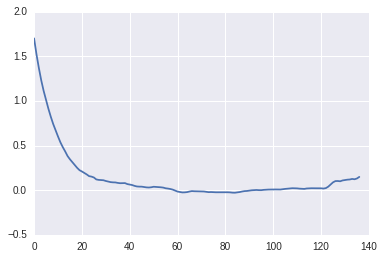

In [32]:
%matplotlib inline
plt.plot(df_y.ppo)

In [14]:
# fake data
n = len(df_y[df_y.close>14.3])
m = len(df_y[df_y.close<=14.3])
msk = df_y.close>14.3
df_y.loc[msk, 'down'] = np.random.uniform(0.3,1,[n])
df_y.loc[msk, 'up'] = 0
df_y.loc[~msk, 'down'] = 0
df_y.loc[~msk, 'up'] = np.random.uniform(0.3,1,[m])

In [265]:
a = np.array([1,2,3,4])
b = np.array([2,3,4,5])
a @ b

40

In [282]:
def read_weight(fname='data/weight.txt'):
    wdict = {}
    with open(fname) as f:
        for line in f:
            line = line.rstrip()
            wdict[line.split(',')[0]] = float(line.split(',')[1])
    return wdict 

In [306]:
def get_init_share(shareDict):
    min_ = min(list(shareDict.values()))
    for k, v in shareDict.items():
        shareDict[k] = v * 100 / min_
    return shareDict

# backtest

In [68]:
X = np.vstack((x_1, x_2, x_4)).T
X = X[:-1]

In [ ]:
# %load common.py
def scalify(l):
    if len(l) > 1:
        raise ValueError('Not only one element!')  
    else:
        return l[0]

